# Student Practice NLP demo

In [ ]:
#@title Используемые модели

# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

!pip install -q flair pytextrank rouge summa stanza news-please

# !pip install transformers
# !pip install sentencepiece

from rouge import Rouge 
rouge = Rouge()

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, Counter
from itertools import chain
from operator import itemgetter

###################################### ner #####################################
from flair.models import SequenceTagger
from flair.data import Sentence
import flair

flair.device = torch.device(device)
ner_tagger = SequenceTagger.load('ner-fast')

def nltk_ner_splitter(news: str):
    return [
        Sentence(sentence)
        for sentence in sent_tokenize(news)
    ]

def split_news(news):
    splitted = nltk_ner_splitter(news["content"])
    splitted.append(Sentence(news["title"]))
    if isinstance(news["description"], str):
        splitted.extend(
            nltk_ner_splitter(news["description"])
        )
    return [sentence for sentence in splitted if len(sentence.text.strip())!=0]

###################################### sa ######################################
# (stanza) NEW MODEL
import stanza
sa_model = stanza.Pipeline(lang='en', processors='tokenize,sentiment')

def sa_sentence(text: str):
    doc = sa_model(text)
    return doc.sentences[0].sentiment - 1

# OLD MODEL
# from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
# from scipy.special import softmax

# SA_MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
# sa_tokenizer = AutoTokenizer.from_pretrained(SA_MODEL)
# sa_config = AutoConfig.from_pretrained(SA_MODEL)
# sa_model = AutoModelForSequenceClassification.from_pretrained(SA_MODEL).to(device)

# def sa_eval(text : str):
#     encoded_input = sa_tokenizer(text, return_tensors='pt').to(device)
#     output = sa_model(**encoded_input)
#     return output[0][0].cpu()

# def sa_score(output : list):
#     scores = output.detach().numpy()
#     scores = softmax(scores)

#     return {
#         sa_config.label2id[i] : scores[i].item()
#         for i in range(3)
#     }

# def sa_sentence(text: str):
#     try:
#         return sa_score(sa_eval(text))
#     except Exception as e:
#         return None

# sa_dict = {
#     "negative": -1,
#     "neutral": 0,
#     "positive": 1
# }

# def get_sentiment(score: dict):
#     return max(score, key=score.get)

# def the_most(key: str, scores: list):
#     st = max(enumerate(scores), key=lambda sa: sa[1][key])
#     return {
#         "sentence_number": st[0], 
#         f"{key} score": st[1][key]
#     }

###################################### es ######################################
# summa
from summa.summarizer import summarize as summa_summarize

# pytextrank
import spacy
pytr = spacy.load("en_core_web_sm")
import pytextrank
pytr.add_pipe("textrank", last=True)
from math import sqrt

def pytr_summarize(text: str, limit_phrases=5, limit_sentences=None, ratio=0.2):
    doc = pytr(text)
    sents = list(doc.sents)
    sent_bounds = [[s.start, s.end, set([])] for s in sents]
    if limit_sentences is None:
        limit_sentences = int(len(sents) * ratio)

    # top-ranked phrases
    phrase_id = 0
    unit_vector = []
    for p in doc._.phrases:
        unit_vector.append(p.rank)
        for chunk in p.chunks:
            for sent_start, sent_end, sent_vector in sent_bounds:
                if chunk.start >= sent_start and chunk.end <= sent_end:
                    sent_vector.add(phrase_id)
                    break

        phrase_id += 1
        if phrase_id == limit_phrases:
            break

    sum_ranks = sum(unit_vector)
    unit_vector = [rank/sum_ranks for rank in unit_vector]

    # minimal distance sentences
    sent_rank = {}
    sent_id = 0
    for sent_start, sent_end, sent_vector in sent_bounds:
        sum_sq = 0.0
        for phrase_id in range(len(unit_vector)):
            if phrase_id not in sent_vector:
                sum_sq += unit_vector[phrase_id]**2.0
        sent_rank[sent_id] = sqrt(sum_sq)
        sent_id += 1
    sent_rank = sorted(sent_rank.items(), key=itemgetter(1)) 

    # соблюдать очерёдность предложений в тексте
    return " ".join([sents[sent_id].text for sent_id, rank in sent_rank[:limit_sentences]])


###################################### as ######################################
# pegasus
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
pegasus_tokenizer = AutoTokenizer.from_pretrained("google/pegasus-large")
pegasus_model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-large").to(device)

def pegasus_summarize(news: str):
    pegasus_inputs = pegasus_tokenizer(news, truncation=True, return_tensors="pt").to(device)
    pegasus_summary = pegasus_model.generate(**pegasus_inputs)
    return pegasus_tokenizer.batch_decode(pegasus_summary, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

# t5
from transformers import AutoTokenizer, T5ForConditionalGeneration
t5_tokenizer = AutoTokenizer.from_pretrained("t5-large")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-large").to(device)

def t5_summarize(text, max_length=150):
    input_ids = t5_tokenizer("summarize: " + text, truncation=True, return_tensors="pt", add_special_tokens=True).to(device)
    generated_ids = t5_model.generate(input_ids=input_ids, max_length=max_length, early_stopping=True)
    preds = t5_tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)

    return preds[:preds.rfind(".")+1]

In [ ]:
#@title Датасет новостей
from pandas.core import describe
import random
import numpy as np
import pandas as pd
import json
from datetime import datetime as dt

import matplotlib.pyplot as plt

data = pd.read_json("data/data.json")

data.date = [
    dt.fromtimestamp(int(list(date["$date"].values())[0]) / 1e3)
    if "$date" in date.keys()
    else pd.NaT
    for date in data.date
]
data.description = [
    desc
    if isinstance(desc, str)
    else np.NaN
    for desc in data.description
]

with_desc__indx = [
    i
    for i in range(len(data))
    if isinstance(data.loc[i]["description"], str)
]

Mounted at /content/up_nlp/


Датасеты:
 - [BBC News Archive](https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive)
 - [News Articles](https://www.kaggle.com/datasets/asad1m9a9h6mood/news-articles)
 - [CNN News Articles from 2011 to 2022](https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning)

Общее число статей -- 42635, из них статей с датами -- 40508. Статьи без дат относятся к датасету `BBC News Data`, в котором представлены статьи за 2004-2005 годы. Статьи, даты которых указаны, датированы 2011-2022 годами: самая старая -- `2011.08.24`, самая новая -- `2022.03.21`. 

Основные категории статей:
 - `business`
 - `entertainment`
 - `health`
 - `politics`
 - `sport`
 - `tech`
 - `travel`
Новости, помеченные как `news`, как правило, являются общими новостями. В датасете `CNN News Articles` для новостей также указывалась их географическая принадлежность. Более подробная статистика по категориям представлена в таблице ниже.

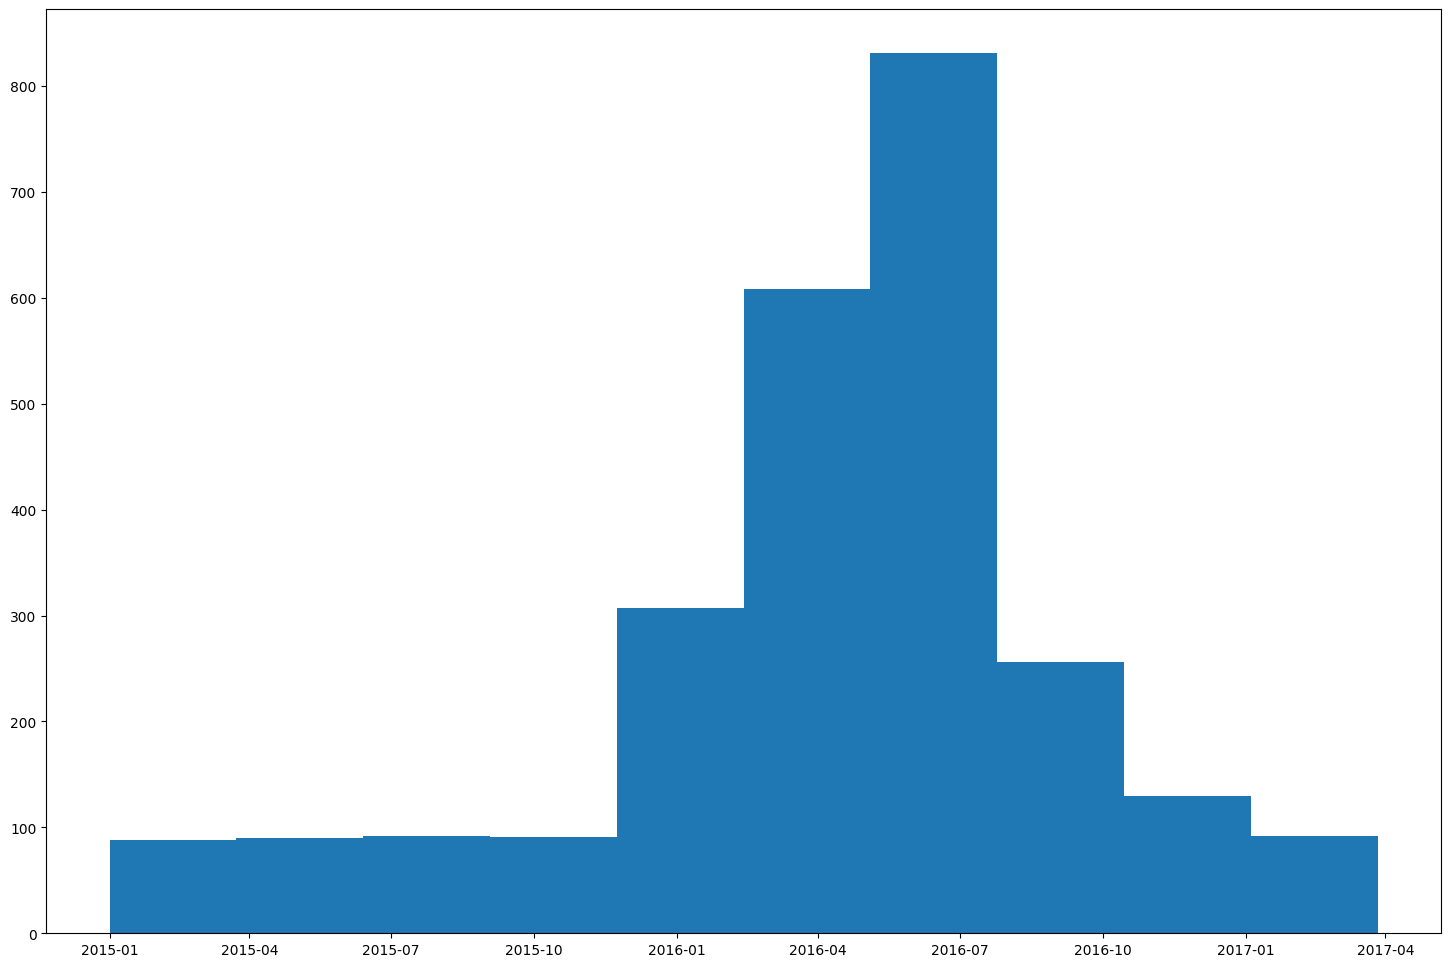

In [ ]:
#@title Распределение новостей по датам
SOURCE = "The News" #@param ["BBC News", "The News", "CNN"]

if SOURCE == "BBC News":
    print("Данные в датасете `BBC News` предоставлены без дат")
else:
    df_view = data.loc[data.source == SOURCE]
    # plt.hist(
    #     df_view.date[df_view.date.notnull()]
    # );
    (df_view.date[
        df_view.date.notnull()
    ].hist(
        figsize=(18,12),
        grid=False,
    ))
    del df_view

In [ ]:
#@title Самые популярные именованные сущности в датасете и их окраска

with open("data/sa4ner__stats.json", "r") as file:
    stats = json.load(file)

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats[key] = defaultdict(list, stats[key])

print({key: len(stats[key]) for key in ["PER", "LOC", "ORG", "MISC"]})

indx = {
    "ALL": stats["SAMPLES"],
    "BBC News": [
        ind
        for ind in data.loc[data.source == "BBC News"].index
        if ind in stats["SAMPLES"]
    ],
    "The News": [
        ind
        for ind in data.loc[data.source == "The News"].index
        if ind in stats["SAMPLES"]
    ],
    "CNN": [
        ind
        for ind in data.loc[data.source == "CNN"].index
        if ind in stats["SAMPLES"]
    ]
}

#@markdown Предподсчитанные данные
data.loc[indx["ALL"]].groupby("source").count()

{'PER': 66484, 'LOC': 18761, 'ORG': 42720, 'MISC': 30574}


,index,date,title,category,description,content
source,,,,,,
BBC News,2127,0,2127,2127,0,2127
CNN,8100,8100,8100,8100,8098,8100
The News,2585,2585,2585,2585,0,2585


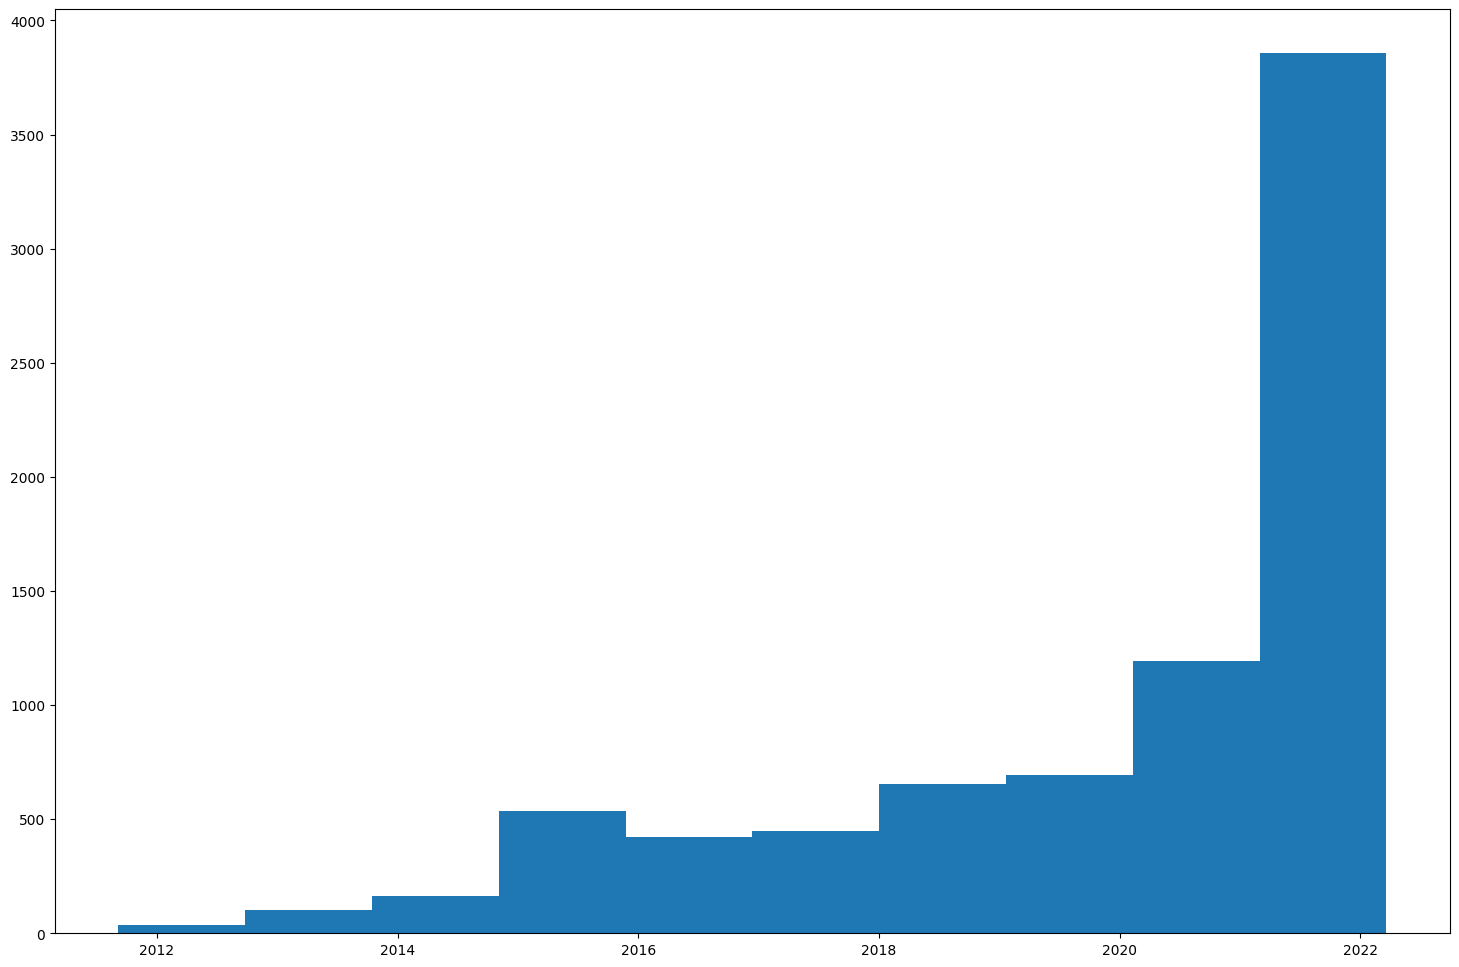

In [ ]:
#@markdown Распределение по датам предподсчитанных данных
SOURCE = "CNN" #@param ["BBC News", "The News", "CNN"]

if SOURCE == "BBC News":
    print("Данные в датасете `BBC News` предоставлены без дат")
else:
    df_view = data.loc[indx[SOURCE]]
    (df_view.date[
        df_view.date.notnull()
    ].hist(
        figsize=(18,12),
        grid=False,
    ))
    del df_view

#@markdown Так как данные не сбалансированы, будем в будущих экспериментах использовать отношение вместо абсолютных величин

In [ ]:
SOURCE = "CNN" #@param ["ALL", "BBC News", "The News", "CNN"]

if SOURCE == "ALL":
    top = {
        "PER": defaultdict(list, sorted(stats["PER"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10]),
        "ORG": defaultdict(list, sorted((_ for _ in stats["ORG"].items() if not _[0].startswith("CNN")), key=lambda ent: len(ent[1]), reverse=True)[:10]),
        "LOC": defaultdict(list, sorted(stats["LOC"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10]),
    }
else:
    if SOURCE == "BBC News":
        print("Данные в датасете `BBC News` предоставлены без дат")
    
    top = {
        "PER": defaultdict(list, sorted(stats["PER"].items(), key=lambda ent: len([_ for _ in ent[1] if _[0] in indx[SOURCE]]), reverse=True)[:10]),
        "ORG": defaultdict(list, sorted((_ for _ in stats["ORG"].items() if not _[0].startswith("CNN")), key=lambda ent: len([_ for _ in ent[1] if _[0] in indx[SOURCE]]), reverse=True)[:10]),
        "LOC": defaultdict(list, sorted(stats["LOC"].items(), key=lambda ent: len([_ for _ in ent[1] if _[0] in indx[SOURCE]]), reverse=True)[:10]),
    }

    for key in top["PER"].keys():
        top["PER"][key] = [_ for _ in top["PER"][key] if _[0] in indx[SOURCE]]
    for key in top["ORG"].keys():
        top["ORG"][key] = [_ for _ in top["ORG"][key] if _[0] in indx[SOURCE]]
    for key in top["LOC"].keys():
        top["LOC"][key] = [_ for _ in top["LOC"][key] if _[0] in indx[SOURCE]]

vf = {
    "PER": list(top["PER"].keys()),
    "ORG": list(top["ORG"].keys()),
    "LOC": list(top["LOC"].keys()),
}

def vf_stats(vf, news):
    st = Counter(_[1] for _ in news[1])
    return {
        "entity": vf,
        "date": data.date[news[0]],
        "index": data.index[news[0]],
        "all": len(news[1]),
        "positive": st[1],
        "neutral": st[0],
        "negative": st[-1]
    }

vf_df = {
    "PER": pd.DataFrame(list(chain.from_iterable([
        [
            vf_stats(vfp, news)
            for news in top["PER"][vfp]
        ]
        for vfp in vf["PER"]
    ]))),
    "ORG": pd.DataFrame(list(chain.from_iterable([
        [
            vf_stats(vfo, news)
            for news in top["ORG"][vfo]
        ]
        for vfo in vf["ORG"]
    ]))),
    "LOC": pd.DataFrame(list(chain.from_iterable([
        [
            vf_stats(vfl, news)
            for news in top["LOC"][vfl]
        ]
        for vfl in vf["LOC"]
    ])))
}
vf_df = {
    "PER": vf_df["PER"].groupby([vf_df["PER"].entity, vf_df["PER"].date.dt.year]).sum(),
    "ORG": vf_df["ORG"].groupby([vf_df["ORG"].entity, vf_df["ORG"].date.dt.year]).sum(),
    "LOC": vf_df["LOC"].groupby([vf_df["LOC"].entity, vf_df["LOC"].date.dt.year]).sum()
}

# sa4ner_dates = data.loc[indx[SOURCE]]
# sa4ner_dates = (
#     sa4ner_dates["date"]
#         .groupby(
#             sa4ner_dates.date.dt.year
#         ).count()
# )

from copy import deepcopy
vf_df_by = deepcopy(vf_df)

vf_df_by["PER"]["positive"] = vf_df_by["PER"]["positive"] / vf_df_by["PER"]["all"]
vf_df_by["PER"]["neutral"] = vf_df_by["PER"]["neutral"] / vf_df_by["PER"]["all"]
vf_df_by["PER"]["negative"] = vf_df_by["PER"]["negative"] / vf_df_by["PER"]["all"]

vf_df_by["ORG"]["positive"] = vf_df_by["ORG"]["positive"] / vf_df_by["ORG"]["all"]
vf_df_by["ORG"]["neutral"] = vf_df_by["ORG"]["neutral"] / vf_df_by["ORG"]["all"]
vf_df_by["ORG"]["negative"] = vf_df_by["ORG"]["negative"] / vf_df_by["ORG"]["all"]

vf_df_by["LOC"]["positive"] = vf_df_by["LOC"]["positive"] / vf_df_by["LOC"]["all"]
vf_df_by["LOC"]["neutral"] = vf_df_by["LOC"]["neutral"] / vf_df_by["LOC"]["all"]
vf_df_by["LOC"]["negative"] = vf_df_by["LOC"]["negative"] / vf_df_by["LOC"]["all"]

In [ ]:
#@title Графики окраски именованных сущностей
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(CATEGORY=["PER", "ORG", "LOC"])
def plot_sa4ner(CATEGORY):
    @interact(ENTITY=vf[CATEGORY])
    def inner(ENTITY):
        st = vf_df[CATEGORY].loc[ENTITY]
        st_by = vf_df_by[CATEGORY].loc[ENTITY]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,12))
        
        bottom = np.zeros(len(st))
        p = ax1.bar(st.index, st.negative, label="negative", bottom=bottom, color="blue")
        bottom += st.negative
        p = ax1.bar(st.index, st.neutral, label="neutral", bottom=bottom, color="green")
        bottom += st.neutral
        p = ax1.bar(st.index, st.positive, label="positive", bottom=bottom, color="orange")
        bottom += st.positive
        ax1.legend(loc="upper left")

        bottom = np.zeros(len(st))
        p = ax2.bar(st_by.index, st_by.negative, label="negative", bottom=bottom, color="blue")
        bottom += st_by.negative
        p = ax2.bar(st_by.index, st_by.neutral, label="neutral", bottom=bottom, color="green")
        bottom += st_by.neutral
        p = ax2.bar(st_by.index, st_by.positive, label="positive", bottom=bottom, color="orange")
        bottom += st_by.positive
        
        plt.title(f"{ENTITY} occurancies")
        plt.show()

        examples = {-1: [], 0: [], 1: []}
        for news in top[CATEGORY][ENTITY]:
            for sentence in news[1]:
                examples[sentence[1]].append((news[0], sentence[0]))
        examples = {
            -1: random.choice(examples[-1]),
            0: random.choice(examples[0]),
            1: random.choice(examples[1]),
        }
        print("EXAPLES:")
        print('\033[91m' + f"\n\tNEGATIVE: {(split_news(data.loc[examples[-1][0]])[examples[-1][1]].text)}")
        print('\033[94m' + f"\n\tNEUTRAL: {(split_news(data.loc[examples[0][0]])[examples[0][1]].text)}")
        print('\033[92m' + f"\n\tPOSITIVE: {(split_news(data.loc[examples[1][0]])[examples[1][1]].text)}")

interactive(children=(Dropdown(description='CATEGORY', options=('PER', 'ORG', 'LOC'), value='PER'), Output()),…

In [ ]:
#@title Суммаризация

from pprint import pprint

NEWS_ID = 36063 #@param {type:"integer"}

news = data.loc[NEWS_ID]
news

index                                                      36063
source                                                       CNN
date                                         2019-12-05 00:00:00
title          Jose Mourinho humbled on return to Old Traffor...
category                                                   sport
description    Jose Mourinho's return to Old Trafford on Wedn...
content        (CNN)Jose Mourinho's return to Old Trafford on...
Name: 36063, dtype: object

Использованные модели:
 - Экстрактивные
    - [textrank](https://github.com/summanlp/textrank)
    - [pytextrank](https://derwen.ai/docs/ptr/start/)
 - Абстрактивные
    - [PEGASUS_LARGE](https://huggingface.co/google/pegasus-large)
    - [T5](https://huggingface.co/mrm8488/t5-large)

    

In [ ]:
#@markdown Суммаризация выбранной новости
summaries = {
    "reference": news["description"],
    "summa": summa_summarize(news["content"]),
    "pytextrank": pytr_summarize(news["content"]),
    "pegasus": pegasus_summarize(news["content"]),
    #"t5": t5_summarize(news["content"])
}
try:
    summaries["t5"] = t5_summarize(news["content"])
except:
    pass
summaries

{'reference': "Jose Mourinho's return to Old Trafford on Wednesday was anything but special. The former Manchester United boss was humbled as his Spurs side succumbed 2-1 with two goals from Marcus Rashford outweighing a first half strike from Dele Ali.",
 'summa': 'The former Manchester United boss was humbled as his Spurs side succumbed 2-1 with two goals from Marcus Rashford outweighing a first half strike from Dele Ali.The Portuguese manager, who joined Tottenham last month, took charge of United for 144 matches between July 2016 and December 2018 until a 3-1 hammering away to Liverpool ended his reign.\nSince arriving in north London, Mourinho has cut a contrasting figure to the brash egotist that first sauntered into the Premier League in 2004 after winning the European Champions League with Porto.Marcus Rashford of Manchester United scores his team\'s first goal in a 2-1 win over Tottenham.\nAlli restored parity five minutes before the break after a sublime first touch allowed h

In [ ]:
#@markdown Измерение точности суммаризации при помощи метрики ROUGE
scores = {
    "summa": rouge.get_scores(summaries["summa"], summaries["reference"]),
    "pytextrank": rouge.get_scores(summaries["pytextrank"], summaries["reference"]),
    "pegasus": rouge.get_scores(summaries["pegasus"], summaries["reference"]),
    #"t5": rouge.get_scores(summaries["t5"], summaries["reference"])
}
try:
    scores["t5"] = rouge.get_scores(summaries["t5"], summaries["reference"])
except:
    pass
pprint(scores)

{'pegasus': [{'rouge-1': {'f': 0.16161615693500678,
                          'p': 0.12903225806451613,
                          'r': 0.21621621621621623},
              'rouge-2': {'f': 0.035714281230867916,
                          'p': 0.02702702702702703,
                          'r': 0.05263157894736842},
              'rouge-l': {'f': 0.16161615693500678,
                          'p': 0.12903225806451613,
                          'r': 0.21621621621621623}}],
 'pytextrank': [{'rouge-1': {'f': 0.2213740433759688,
                             'p': 0.1288888888888889,
                             'r': 0.7837837837837838},
                 'rouge-2': {'f': 0.14207650087133092,
                             'p': 0.07926829268292683,
                             'r': 0.6842105263157895},
                 'rouge-l': {'f': 0.2213740433759688,
                             'p': 0.1288888888888889,
                             'r': 0.7837837837837838}}],
 'summa': [{'rouge-1': {'f': 0.18

In [ ]:
#@title Статистика сентиментанализа для отдельной статьи
def sa4ner_eval(news): # first arg `stats: dict, `
    splitted = split_news(news)

    sa_stats = [sa_sentence(sentence.text) for sentence in splitted]
    # splitted = [splitted[i] for i in range(len(sa_stats)) if sa_stats[i]!=None]
    # sa_stats = [sa_stats[i] for i in range(len(sa_stats)) if sa_stats[i]!=None]
    ner_tagger.predict(splitted)

    sample_stats = {
        "PER":  defaultdict(list),
        "LOC":  defaultdict(list),
        "ORG":  defaultdict(list),
        "MISC": defaultdict(list)
    }     
    
    # ---
    # `sa`-statistic is added for analysis on full dataset
    # title
    # title_sa = sa_dict[get_sentiment(sa_stats[-1])]
    title_sa = sa_stats[-1]
    for entity in splitted[len(splitted)-1].get_spans("ner"):
        # title is the `minus 1-st` sentence in the list of sentences
        sample_stats[entity.tag][entity.text].append(
            (-1, title_sa)
        )
    # content and description
    for sentence_i in range(len(splitted)-1):
        # sentence_sa = sa_dict[get_sentiment(sa_stats[sentence_i])]
        sentence_sa = sa_stats[sentence_i]
        for entity in splitted[sentence_i].get_spans("ner"):
            sample_stats[entity.tag][entity.text].append(
                (sentence_i, sentence_sa)
            )
    # ---

    # # write stats for full dataset
    # if not news["index"] in stats["SAMPLES"]:
    #     stats["SAMPLES"].append(news["index"])
    #     for key in sample_stats.keys():
    #         for entity in sample_stats[key].keys():
    #             stats[key][entity].append((news["index"], sample_stats[key][entity]))
    
    # but return stats for the sample
    return {
        "SENTENCES": splitted,
        "SA": sa_stats,
        "NER": sample_stats
    }

news_stats = sa4ner_eval(news)

# most_positive = the_most("positive", sample_stats["SA"][:-1])
# print(sample_stats["SENTENCES"][most_positive["sentence_number"]]) 
# print(most_positive)

# most_negative = the_most("negative", sample_stats["SA"][:-1])
# print(sample_stats["SENTENCES"][most_negative["sentence_number"]]) 
# print(most_negative)

import re

def colorize(data: dict, ENTS: list):
    CLRS = {
        -1: '\033[91m',     # red
        0 : '\033[94m',     # blue
        1 : '\033[92m',     # green
        None : '\033[97m'
    }

    text = [s.text for s in data["SENTENCES"]]

    for ENT in ENTS:
        for ent, stats in data["NER"][ENT].items():
            for stat in stats:
                text[stat[0]] = re.sub(ent, CLRS[stat[1]]+ent+CLRS[None], text[stat[0]])

    data[f"TEXT_SA4NER_{ENTS}"] = " ".join(text)

@interact(
    ENTS=widgets.SelectMultiple(
        options=["PER", "ORG", "LOC", "MISC"], value=[], description="Named entity: ")
)
def colorize_inter(ENTS: list):
    CLRS = {
        -1: '\033[91m',     # red
        0 : '\033[94m',     # blue
        1 : '\033[92m',     # green
        None : '\033[97m'
    }
    print(CLRS[-1]+": NEGATIVE :"+CLRS[0]+": NEUTRAL :"+CLRS[1]+": POSITIVE :"+CLRS[None])

    text = [s.text for s in news_stats["SENTENCES"]]

    for ENT in ENTS:
        for ent, stats in news_stats["NER"][ENT].items():
            for stat in stats:
                text[stat[0]] = re.sub(ent, CLRS[stat[1]]+ent+CLRS[None], text[stat[0]])

    print(" ".join(text))

interactive(children=(SelectMultiple(description='Named entity: ', options=('PER', 'ORG', 'LOC', 'MISC'), valu…

In [ ]:
#@title 
colorize(news_stats, ["MISC"])
news_stats.keys();

In [ ]:
#@title 
from newsplease import NewsPlease

ARTICLE_URL = 'https://www.reuters.com/markets/deals/first-citizens-said-be-near-deal-silicon-valley-bank-bloomberg-news-2023-03-26/' #@param {type:"string"}

article = NewsPlease.from_url(ARTICLE_URL)
article = {
    "url": ARTICLE_URL,
    "date": article.date_publish,
    "title": article.title,
    "description": article.description,
    "content": article.maintext
}

article_stats = sa4ner_eval(article)

@interact(
    ENTS=widgets.SelectMultiple(
        options=["PER", "ORG", "LOC", "MISC"], value=[], description="Named entity: ")
)
def colorize_inter(ENTS: list):
    CLRS = {
        -1: '\033[91m',     # red
        0 : '\033[94m',     # blue
        1 : '\033[92m',     # green
        None : '\033[97m'
    }
    print(CLRS[-1]+": NEGATIVE :"+CLRS[0]+": NEUTRAL :"+CLRS[1]+": POSITIVE :"+CLRS[None])

    text = [s.text for s in article_stats["SENTENCES"]]

    for ENT in ENTS:
        for ent, stats in article_stats["NER"][ENT].items():
            for stat in stats:
                text[stat[0]] = re.sub(ent, CLRS[stat[1]]+ent+CLRS[None], text[stat[0]])

    print(" ".join(text))

interactive(children=(SelectMultiple(description='Named entity: ', options=('PER', 'ORG', 'LOC', 'MISC'), valu…

In [ ]:
#@markdown Суммаризация новости из источника
summaries = {
    "reference": article["description"],
    "summa": summa_summarize(article["content"]),
    "pytextrank": pytr_summarize(article["content"]),
    "pegasus": pegasus_summarize(article["content"]),
    #"t5": t5_summarize(article["content"])
}
try:
    summaries["t5"] = t5_summarize(article["content"])
except:
    pass
summaries

{'reference': 'U.S. regulators said on Monday they would backstop a deal for regional lender First Citizens BancShares to acquire failed Silicon Valley Bank, triggering an estimated $20 billion hit to a government-run insurance fund.',
 'summa': 'March 27 (Reuters) - U.S. regulators said on Monday they would backstop a deal for regional lender First Citizens BancShares to acquire failed Silicon Valley Bank, triggering an estimated $20 billion hit to a government-run insurance fund.\nThe deal comes after the Federal Deposit Insurance Corporation (FDIC) took over Silicon Valley Bank on March 10 after depositors rushed to pull out their money in a bank run that also brought down Signature Bank and wiped out more than half the market value of several other U.S. regional lenders.\n"The FDIC’s sale of SVB helps show business can go on as usual for the banking industry," a team of Wells Fargo analysts led by Mike Mayo said in a note on Monday.\nInstead, it said it granted equity appreciation 

In [ ]:
#@markdown Измерение точности суммаризации при помощи метрики ROUGE
scores = {
    "summa": rouge.get_scores(summaries["summa"], summaries["reference"]),
    "pytextrank": rouge.get_scores(summaries["pytextrank"], summaries["reference"]),
    "pegasus": rouge.get_scores(summaries["pegasus"], summaries["reference"]),
    #"t5": rouge.get_scores(summaries["t5"], summaries["reference"])
}
try:
    scores["t5"] = rouge.get_scores(summaries["t5"], summaries["reference"])
except:
    pass
pprint(scores)

{'pegasus': [{'rouge-1': {'f': 0.6078431329488658,
                          'p': 0.44285714285714284,
                          'r': 0.96875},
              'rouge-2': {'f': 0.548672562236667,
                          'p': 0.3875,
                          'r': 0.9393939393939394},
              'rouge-l': {'f': 0.6078431329488658,
                          'p': 0.44285714285714284,
                          'r': 0.96875}}],
 'pytextrank': [{'rouge-1': {'f': 0.4507042218607419,
                             'p': 0.2909090909090909,
                             'r': 1.0},
                 'rouge-2': {'f': 0.35106382689282484,
                             'p': 0.2129032258064516,
                             'r': 1.0},
                 'rouge-l': {'f': 0.4507042218607419,
                             'p': 0.2909090909090909,
                             'r': 1.0}}],
 'summa': [{'rouge-1': {'f': 0.2869955132369443,
                        'p': 0.16753926701570682,
                       